In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks/ITS Labs/Lab 09/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/ITS Labs/Lab 09


In [0]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

604 features detected in image1
594 features detected in image2
604 features matched
Homography = 
[[ 2.74195265e+00 -1.11870420e+01  4.69822692e+01]
 [ 9.13372998e-01 -5.36520453e+00  1.46146525e+02]
 [ 1.04567517e-02 -4.99247077e-02  1.00000000e+00]]
output size:  (1400, 800)
Press enter or any key on one of the images to exit


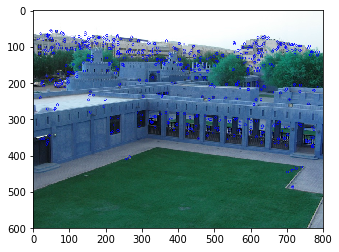

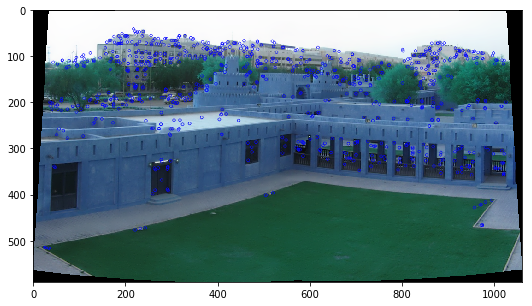

In [22]:
# coding: utf-8
import cv2, numpy as np
import matplotlib.pyplot as plt

## ---------------------------------------------------------------------
## 3.1  Extract SURF keypoints and descriptors from an image. ----------
def extract_features_and_descriptors(image):

  ## Convert image to grayscale (for SURF detector).
  ## TODO: 
  gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  
  ## Detect SURF features and compute descriptors.
  ## TODO
  keypoints = []
  descriptors = []
  
  
  #defining feature extractor
  detector = cv2.xfeatures2d.SURF_create()
  detector.setHessianThreshold(1000)
  keypoints, descriptors = detector.detectAndCompute(gray_image, None)
  
  
  
  #append extracted data to seperate arrays
  #keypoints.append(keypoint)
  #descriptors.append(descriptor)
  
  return (keypoints, descriptors)
  
## --------------------------------------------------------------------
def detect_features(grey_image):
  surf = cv2.FeatureDetector_create("SURF")
  surf.setDouble("hessianThreshold", 1000)
  return surf.detect(grey_image)
  
def extract_descriptors(grey_image, keypoints):
  surf = cv2.DescriptorExtractor_create("SURF")
  return surf.compute(grey_image, keypoints)[1]
  

## --------------------------------------------------------------------
## 3.2 Find corresponding features between the images. ----------------
def find_correspondences(keypoints1, descriptors1, keypoints2, descriptors2):

  ## Find corresponding features.
  match = match_flann(descriptors1, descriptors2)

  ## Look up corresponding keypoints.
  points1 = []
  points2 = []
  
  ## TODO
  
  
  for kp1 in keypoints1:
    points1.append(kp1.pt)
  for kp2 in keypoints2:
    points2.append(kp2.pt)

  return (points1, points2)


## ---------------------------------------------------------------------
## 3.3  Calculate the size and offset of the stitched panorama. --------
def calculate_size(size_image1, size_image2, homography):
  
  ## Calculate the size and offset of the stitched panorama.
  ## TODO: (Overwrite the following 2 lines with your answer.)
  offset = (10, 10)
  size   = (1400, 800)
  
  ## Update the homography to shift by the offset
  homography[0,2] += offset[0]
  homography[1,2] += offset[1]

  return (size, offset)


## ---------------------------------------------------------------------
## 3.4  Combine images into a panorama. --------------------------------
def merge_images(image1, image2, homography, size, offset, keypoints):

  ## Combine the two images into one.
  ## TODO
  panorama = np.zeros((size[1], size[0], 3), np.uint8) 
  
  
  
  
  '''#M = cv2.getPerspectiveTransform(offset[0], offset[1])
  panorama = cv2.warpPerspective(image1, homography, size)
  
  place_image(panorama, image2, offset[0], offset[1])'''
  
  
  image_array = []
  
  image_array.append(image1)
  image_array.append(image2)

  st = cv2.createStitcher()
  ret, panorama = st.stitch(image_array)

  return panorama











##------------------------------------------------------------------------
##------------------------------------------------------------------------
##------------------------------------------------------------------------
##---- No need to change anything below this point. ----------------------
##------------------------------------------------------------------------
##------------------------------------------------------------------------

  
def place_image(output, image, x, y):
  minx = max(x,0)
  miny = max(y,0)
  maxx = min(x+image.shape[1],output.shape[1])
  maxy = min(y+image.shape[0],output.shape[0])
  output[miny:maxy, minx:maxx] = image[miny-y:maxy-y, minx-x:maxx-x]

def match_flann(desc1, desc2, r_threshold = 0.5):
  'Finds strong corresponding features in the two given vectors.'
  ## Adapted from <http://stackoverflow.com/a/8311498/72470>.
  
  if len(desc1) == 0 or len(desc2) == 0:
    print("No features passed into match_flann")
    return []

  ## Build a kd-tree from the second feature vector.
  FLANN_INDEX_KDTREE = 1  # bug: flann enums are missing
  flann = cv2.flann_Index(desc2, {'algorithm': FLANN_INDEX_KDTREE, 'trees': 4})

  ## For each feature in desc1, find the two closest ones in desc2.
  (idx2, dist) = flann.knnSearch(desc1, 2, params={}) # bug: need empty {}
  #print(idx2.shape)
  #idx2 = idx2[0]

  
  
  

  ## Create a mask that indicates if the first-found item is sufficiently
  ## closer than the second-found, to check if the match is robust.
  mask = dist[:,0] / dist[:,1] < r_threshold
  
  ## Only return robust feature pairs.
  idx1  = np.arange(len(desc1))
  pairs = np.int32(list(zip(idx1, idx2[:,0])))
  return [(i,j) for (i,j) in pairs[mask]]


def draw_correspondences(image1, image2, points1, points2):
  'Connects corresponding features in the two images using yellow lines.'

  ## Put images side-by-side into 'image'.
  (h1, w1) = image1.shape[:2]
  (h2, w2) = image2.shape[:2]
  image = np.zeros((max(h1, h2), w1 + w2, 3), np.uint8)
  image[:h1, :w1] = image1
  image[:h2, w1:w1+w2] = image2
  
  ## Draw yellow lines connecting corresponding features.
  for (x1, y1), (x2, y2) in zip(np.int32(points1), np.int32(points2)):
    cv2.line(image, (x1, y1), (x2+w1, y2), (0, 255, 255))

  return image




## ---------------------------------------------------------------------

def show(name, im):
  if im.dtype == np.complex128:
    raise Exception("OpenCV can't operate on complex valued images")
  cv2.namedWindow(name)
  cv2.imshow(name, im)
  cv2.waitKey(1)
  
if __name__ == "__main__":

  ## Load images.
  image1 = cv2.imread("input/Image1.jpg")
  image2 = cv2.imread("input/Image2.jpg")

  ## Detect features and compute descriptors.
  keypoints1, descriptors1 = extract_features_and_descriptors(image1)
  keypoints2, descriptors2 = extract_features_and_descriptors(image2)
  print(len(keypoints1), "features detected in image1")
  print(len(keypoints2), "features detected in image2")
  
  #show("Image1 features", cv2.drawKeypoints(image1, keypoints1, image1, color=(0,0,255)))
  #show("Image2 features", cv2.drawKeypoints(image2, keypoints2, image2, color=(0,0,255)))
  
  img1 = cv2.drawKeypoints(image1, keypoints1, image1, color=(0,0,255))
  img2 = cv2.drawKeypoints(image2, keypoints2, image2, color=(0,0,255))
  
  plt.imshow(img1)
  plt.imshow(img2)
  
  ## Find corresponding features.
  points1, points2 = find_correspondences(keypoints1, descriptors1, keypoints2, descriptors2)
  points1 = np.array(points1, dtype=float)
  points2 = np.array(points2, dtype=float)
  print(len(points1), "features matched")
  
  mf = len(points1)
  mf = len(points1) if len(points1) < len(points2) else len(points2)

  ## Visualise corresponding features.
  correspondences = draw_correspondences(image1, image2, points1, points2)
  #plt.imwrite("correspondences.jpg", correspondences)
  plt.figure(figsize=(20,5))
  plt.imshow(correspondences)
  
  ## Find homography between the views.
  if len(points1) < 4 or len(points2) < 4:
    print("Not enough features to find a homography")
    homography = np.identity(3, dtype=float)
  else:
    #(homography, _) = cv2.findHomography(points2, points1, method=cv2.RANSAC)
    (homography, channels) = cv2.findHomography(points2[:mf,], points1[:mf,], cv2.RANSAC)
    homography = np.matrix(homography)
  print("Homography = ")
  print(homography)
  plt.imshow(homography)
  
  ## Calculate size and offset of merged panorama.
  (size, offset) = calculate_size(image1.shape[:2], image2.shape[:2], homography)
  size = tuple(np.asarray(size).flatten().astype(int).tolist())
  offset = tuple(np.asarray(offset).flatten().astype(int).tolist())
  print("output size: ", size)
  
  ## Finally combine images into a panorama.
  panorama = merge_images(image1, image2, homography, size, offset, (points1, points2))
  #cv2.imwrite("panorama.jpg", panorama)
  plt.imshow(panorama)
  
    
  
  import sys, select 
  print("Press enter or any key on one of the images to exit")
  while True:
    if cv2.waitKey(100) != -1:
      break
    # http://stackoverflow.com/questions/1335507/keyboard-input-with-timeout-in-python
    i, o, e = select.select( [sys.stdin], [], [], 0.1 )
    if i:
      break
